# **Complex Deep Learning Architectures in predicting Stock Prices**

This notebook explores the effectiveness of three models — **Long Short-Term Memory (LSTM)**, **Temporal Fusion Transformer (TFT)** and **Artificial Neural Network (ANN)** — in predicting the *S&P 500* stock prices. The analysis aims to understand why and how complex deep learning models, such as **LSTM** and **TFT**, outperform a traditional feed-forward neural network (**ANN**), considered as the baseline model.

Each model predicts the S&P 500 closing price based on the previous days' closing prices. The comparison considers two time horizons: the previous 5 days and the previous 20 days. Performance metrics include Mean Absolute Error (**MAE**), Root Mean Square Error (**RMSE**), and Mean Absolute Percentage Error (**MAPE**).

The results underscore the superior predictive capabilities of advanced deep learning models like LSTM and TFT in capturing the intricate dynamics of stock prices.

## Importing Tensorflow and Keras Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, Input, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import warnings
import tensorflow as tf
from tabulate import tabulate

warnings.filterwarnings("ignore")

## Fetching data & preprocessing

The time range considered in the analysis goes from *2010-01-01* to *2019-02-28*

In [2]:
ticker_symbol = "^GSPC"

# Date range

start_date = "2010-01-01"
end_date = "2019-02-28"

# Data downloading

sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)
closing_prices = sp500_data['Close'].values.reshape(-1, 1)

In [3]:
# Function to create lagged features

def create_lag_features(data, lag_days):
    for i in range(1, lag_days + 1):
        data[f'Close_{i}d'] = data['Close'].shift(i)
    return data.dropna()

# Function to create NN model structure

def display_model_structure(model):
    print(model.summary())
    for layer in model.layers:
        print(f"{layer.name}: {layer.input_shape} => {layer.output_shape}")

In [4]:
lag_days = 5
sp500_data = create_lag_features(sp500_data, lag_days)

In [5]:
# First glance at the data

sp500_data.head()

,Open,High,Low,Close,Adj Close,Volume,Close_1d,Close_2d,Close_3d,Close_4d,Close_5d
Date,,,,,,,,,,,
2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000,1144.979980,1141.689941,1137.140015,1136.520020,1132.989990
2010-01-12,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4716160000,1146.979980,1144.979980,1141.689941,1137.140015,1136.520020
2010-01-13,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4170360000,1136.219971,1146.979980,1144.979980,1141.689941,1137.140015
2010-01-14,1145.680054,1150.410034,1143.800049,1148.459961,1148.459961,3915200000,1145.680054,1136.219971,1146.979980,1144.979980,1141.689941
2010-01-15,1147.719971,1147.770020,1131.390015,1136.030029,1136.030029,4758730000,1148.459961,1145.680054,1136.219971,1146.979980,1144.979980


In [6]:
# Features and target extraction - 5-day-lagged features

X = sp500_data[['Close_1d', 'Close_2d', 'Close_3d', 'Close_4d', 'Close_5d']]
y = sp500_data['Close']

In [ ]:
# Feature and target extraction - 20-day-lagged features

X = sp500_data[['Close_1d', 'Close_2d', 'Close_3d', 'Close_4d', 'Close_5d',
                'Close_6d', 'Close_7d', 'Close_8d', 'Close_9d', 'Close_10d',
                'Close_11d', 'Close_12d', 'Close_13d', 'Close_14d', 'Close_15d',
                'Close_16d', 'Close_17d', 'Close_18d', 'Close_19d', 'Close_20d']]
y = sp500_data['Close']

In [7]:
# Train, validation and test split based on date

split_date_validation = '2018-12-01'
split_date_test = '2019-01-01'

# Split masks

mask_validation = sp500_data.index < split_date_validation
mask_test = (sp500_data.index >= split_date_validation) & (sp500_data.index < split_date_test)
mask_fin = sp500_data.index > split_date_test

# Split

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train, X_validation, X_test = X[mask_validation].values, X[mask_test].values, X[mask_fin].values
y_train, y_validation, y_test = y[mask_validation].values, y[mask_test].values, y[mask_fin].values

The time ranges for the train, validation and test sets are:

*   **Train Set**:         from ***2010-01-01*** to ***2018-12-01***
*   **Validation Set**:    from ***2018-12-01*** to ***2019-01-01***
*   **Test Set**:          from ***2019-01-01*** to ***2019-02-28***

We use a single split approach since implementing a cross-validation approach is challenging due to limited computing resources, given the high training times required by deep learning models.


In [8]:
# Data normalization through MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_validation_scaled = scaler_X.transform(X_validation)
y_validation_scaled = scaler_y.transform(y_validation.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [9]:
# Data reshaping - necessary for NN inputs (samples, time steps, features)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_validation_reshaped = X_validation_scaled.reshape((X_validation_scaled.shape[0], 1, X_validation_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 1<sup>st</sup> model: Artificial Neural Network (ANN) - Baseline

The **Artificial Neural Network (ANN)**, comprises an input layer, multiple hidden layers, and an output layer. This architecture utilizes a feed-forward mechanism to process historical stock data (lagged close prices), where neurons within each layer undergo training to discern complex patterns. The model's capacity to generate predictive outputs is a result of its ability to learn and capture subtle relationships within the historical stock dataset.

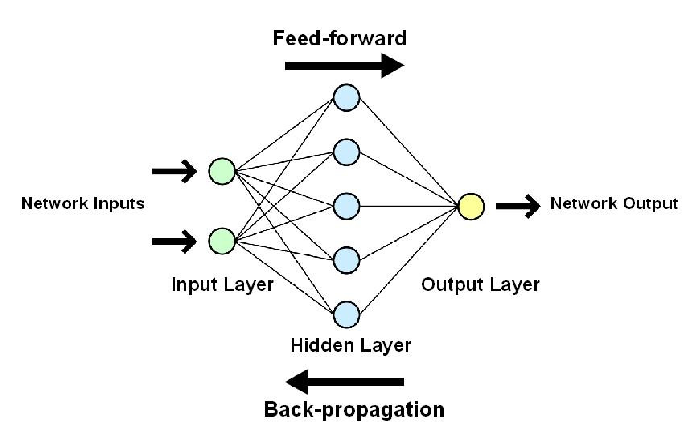

## Building the model

We designed the **Artificial Neural Network (ANN)** with a focus on stock price prediction. The utilization of non-linear activation functions is critical, enabling the model to effectively capture intricate, non-linear relationships between the target close price and lagged close prices.

The architecture consists of **two fully connected layers**, composed by **64** and **32** neurons, respectively. To mitigate overfitting, two Dropout layers are incorporated. The network, is composed of **2497 parameters** (or **3457 parameters** when 20 lagged features make up the training set).

In [10]:
model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

In [ ]:
# Model training with validation set

history = model.fit(
    X_train_reshaped,
    y_train_scaled,
    epochs=50,
    batch_size=64,
    validation_data=(X_validation_reshaped, y_validation_scaled),
    verbose=2
)

Epoch 1/50


35/35 - 0s - loss: 0.0618 - val_loss: 0.0228 - 302ms/epoch - 9ms/step
Epoch 2/50
35/35 - 0s - loss: 0.0312 - val_loss: 0.0038 - 32ms/epoch - 926us/step
Epoch 3/50
35/35 - 0s - loss: 0.0115 - val_loss: 0.0020 - 30ms/epoch - 862us/step
Epoch 4/50
35/35 - 0s - loss: 0.0064 - val_loss: 0.0034 - 29ms/epoch - 836us/step
Epoch 5/50
35/35 - 0s - loss: 0.0051 - val_loss: 0.0020 - 30ms/epoch - 860us/step
Epoch 6/50
35/35 - 0s - loss: 0.0045 - val_loss: 0.0019 - 28ms/epoch - 807us/step
Epoch 7/50
35/35 - 0s - loss: 0.0042 - val_loss: 0.0016 - 29ms/epoch - 823us/step
Epoch 8/50
35/35 - 0s - loss: 0.0037 - val_loss: 0.0014 - 29ms/epoch - 840us/step
Epoch 9/50
35/35 - 0s - loss: 0.0034 - val_loss: 0.0016 - 29ms/epoch - 841us/step
Epoch 10/50
35/35 - 0s - loss: 0.0032 - val_loss: 0.0014 - 32ms/epoch - 909us/step
Epoch 11/50
35/35 - 0s - loss: 0.0031 - val_loss: 0.0018 - 29ms/epoch - 834us/step
Epoch 12/50
35/35 - 0s - loss: 0.0027 - val_loss: 0.0020 - 29ms/epoch - 835us/step
Epoch 13/50
35/35 - 0s - 

## Model architecture

In [11]:
display_model_structure(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 64)             384       
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 dense_1 (Dense)             (None, 1, 32)             2080      
                                                                 
 dropout_1 (Dropout)         (None, 1, 32)             0         
                                                                 
 dense_2 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 2497 (9.75 KB)
Trainable params: 2497 (9.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
dense: (None, 1, 5)

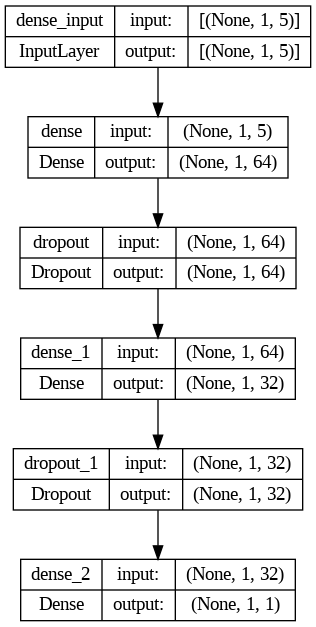

In [12]:
plot_model(model, to_file='ann_model.png', show_shapes=True, show_layer_names=True)

## Prediction

In [ ]:
# Predictions on the training, validation, and test sets

train_predictions = model.predict(X_train_reshaped)
valid_predictions = model.predict(X_validation_reshaped)
test_predictions = model.predict(X_test_reshaped)

# Reshaping to two dimensions

num_samples_train, dim1_train, dim2_train = train_predictions.shape
num_samples_valid, dim1_valid, dim2_valid = valid_predictions.shape
num_samples_test, dim1_test, dim2_test = test_predictions.shape

train_predictions_reshaped = train_predictions.reshape((num_samples_train, dim1_train * dim2_train))
valid_predictions_reshaped = valid_predictions.reshape((num_samples_valid, dim1_valid * dim2_valid))
test_predictions_reshaped = test_predictions.reshape((num_samples_test, dim1_test * dim2_test))

# Invert the predictions to the original scale
train_predictions_inv = scaler_y.inverse_transform(train_predictions_reshaped)
valid_predictions_inv = scaler_y.inverse_transform(valid_predictions_reshaped)
test_predictions_inv = scaler_y.inverse_transform(test_predictions_reshaped)

 1/70 [..............................] - ETA: 3s

2/2 [==============================] - 0s 1ms/step


## Performance evaluation metrics

$$ MAE = \frac{1}{n} \sum_{i=1}^{n} \left| Y_i - \hat{Y}_i \right| $$


$$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2} $$


$$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{Y_i - \hat{Y}_i}{Y_i} \right| \times 100 $$


In [ ]:
# MAE, RMSE, and MAPE for training set

train_mae_ann = mean_absolute_error(y_train, train_predictions_inv)
train_rmse_ann = np.sqrt(mean_squared_error(y_train, train_predictions_inv))
train_mape_ann = mean_absolute_percentage_error(y_train, train_predictions_inv)

print(f"Train MAE: {train_mae_ann:.2f}")
print(f"Train RMSE: {train_rmse_ann:.2f}")
print(f"Train MAPE: {train_mape_ann:.2f}")

Train MAE: 22.30
Train RMSE: 29.68
Train MAPE: 0.01


In [ ]:
# MAE, RMSE, and MAPE for validation set

valid_mae_ann = mean_absolute_error(y_validation, valid_predictions_inv)
valid_rmse_ann = np.sqrt(mean_squared_error(y_validation, valid_predictions_inv))
valid_mape_ann = mean_absolute_percentage_error(y_validation, valid_predictions_inv)

print(f"Validation MAE: {valid_mae_ann:.2f}")
print(f"Validation RMSE: {valid_rmse_ann:.2f}")
print(f"Validation MAPE: {valid_mape_ann:.2f}")

Validation MAE: 86.33
Validation RMSE: 101.21
Validation MAPE: 0.03


In [ ]:
# MAE, RMSE, and MAPE for test set

test_mae_ann = mean_absolute_error(y_test, test_predictions_inv)
test_rmse_ann = np.sqrt(mean_squared_error(y_test, test_predictions_inv))
test_mape_ann = mean_absolute_percentage_error(y_test, test_predictions_inv)

print(f"Test MAE: {test_mae_ann:.2f}")
print(f"Test RMSE: {test_rmse_ann:.2f}")
print(f"Test MAPE: {test_mape_ann:.2f}")

Test MAE: 24.03
Test RMSE: 29.79
Test MAPE: 0.01


## Plotting Predicted Closing Prices vs Actual Closing Prices for the Test Set

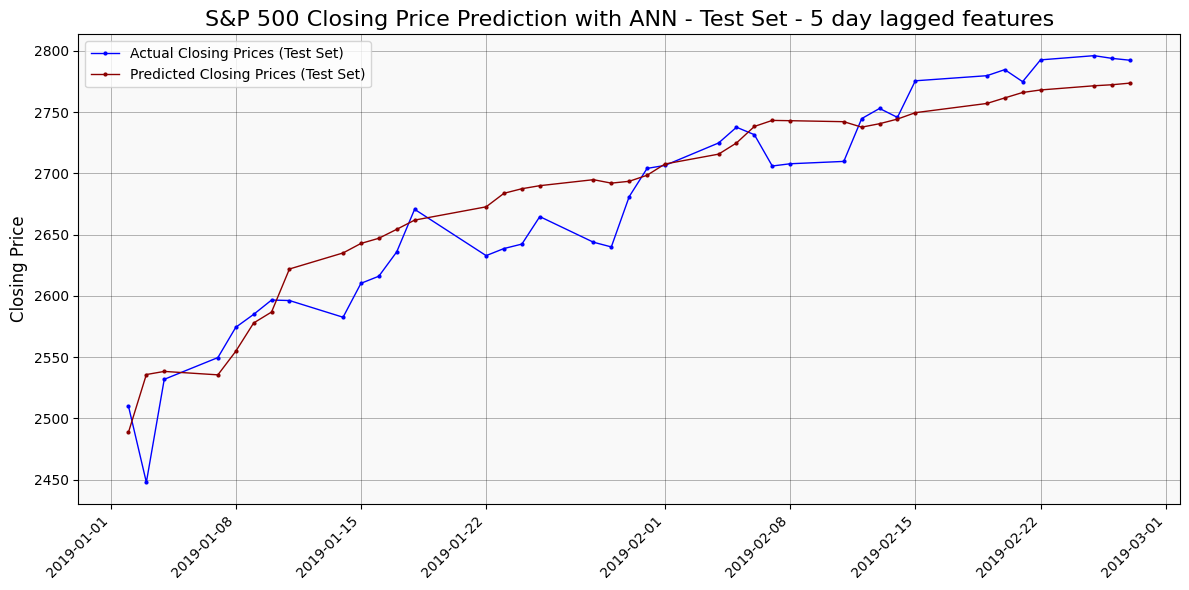

In [ ]:
dates = X[mask_fin].index
dates = pd.to_datetime(dates)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual Closing Prices (Test Set)', color='blue', marker='.', linestyle='-', linewidth=1, markersize=4)
plt.plot(dates, test_predictions_inv, label='Predicted Closing Prices (Test Set)', color='darkred', marker='.', linestyle='-', linewidth=1, markersize=4)

plt.title('S&P 500 Closing Price Prediction with ANN - Test Set - 5 day lagged features', fontsize=16)
plt.ylabel('Closing Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.4)
plt.xticks(rotation=45, ha='right')
plt.gca().set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()

# 2<sup>nd</sup> model: Long Short-Term Memory (LSTM) Network

**Long Short-Term Memory (LSTM)** excel in stock price prediction due to their sequential memory and gating mechanisms. The sequential memory allows LSTMs to retain information over extended sequences, mitigating the vanishing gradient problem common in traditional **ANNs**. Gating mechanisms, including **forget**, **input**, and **output** **gates**, enable LSTMs to selectively filter, incorporate, and expose information. This adaptability makes **LSTMs effective in capturing long-term dependencies** and evolving patterns in time series data.

The performance result below confirm that LSTMs outperform Artificial Neural Networks (ANNs) in modeling the complex and dynamic nature of stock prices.

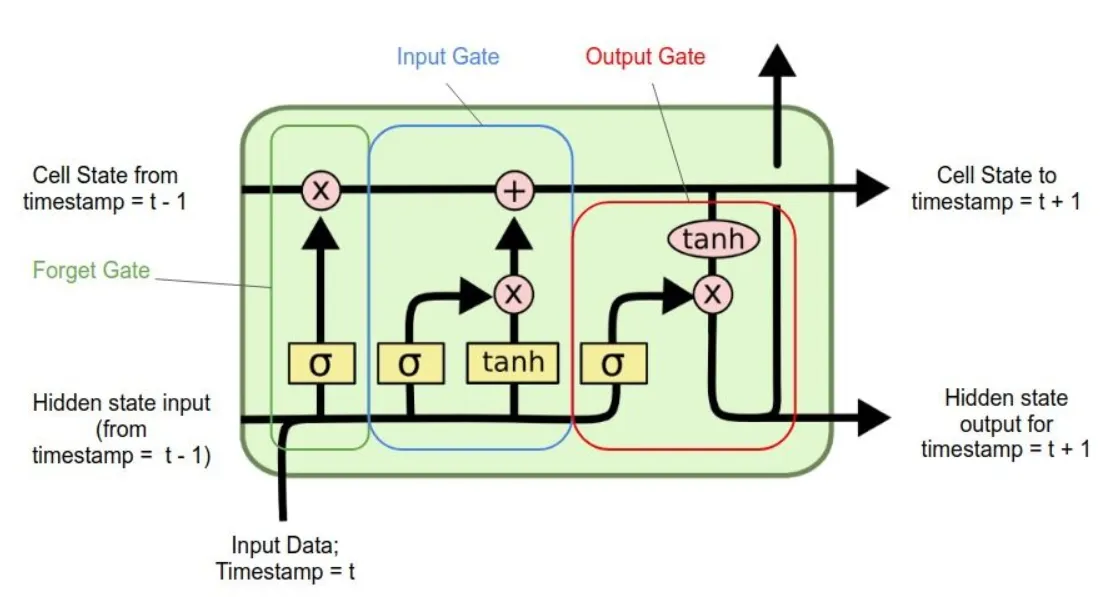

## Building the model

The Model architecture consists in **one LSTM layer composed by 11200 parameters** and trained for 50 epochs.
The Dropout layer is added to prevent overfitting.

In [13]:
model = Sequential()

model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Model training with validation set

history = model.fit(
    X_train_reshaped,
    y_train_scaled,
    epochs=50,
    batch_size=64,
    validation_data=(X_validation_reshaped, y_validation_scaled),
    verbose=2
)

Epoch 1/50


35/35 - 1s - loss: 0.1176 - val_loss: 0.0705 - 909ms/epoch - 26ms/step
Epoch 2/50
35/35 - 0s - loss: 0.0103 - val_loss: 9.9981e-04 - 46ms/epoch - 1ms/step
Epoch 3/50
35/35 - 0s - loss: 0.0052 - val_loss: 0.0017 - 39ms/epoch - 1ms/step
Epoch 4/50
35/35 - 0s - loss: 0.0040 - val_loss: 0.0012 - 37ms/epoch - 1ms/step
Epoch 5/50
35/35 - 0s - loss: 0.0032 - val_loss: 0.0011 - 39ms/epoch - 1ms/step
Epoch 6/50
35/35 - 0s - loss: 0.0027 - val_loss: 0.0011 - 37ms/epoch - 1ms/step
Epoch 7/50
35/35 - 0s - loss: 0.0026 - val_loss: 0.0018 - 38ms/epoch - 1ms/step
Epoch 8/50
35/35 - 0s - loss: 0.0022 - val_loss: 0.0019 - 38ms/epoch - 1ms/step
Epoch 9/50
35/35 - 0s - loss: 0.0023 - val_loss: 0.0021 - 37ms/epoch - 1ms/step
Epoch 10/50
35/35 - 0s - loss: 0.0021 - val_loss: 0.0017 - 38ms/epoch - 1ms/step
Epoch 11/50
35/35 - 0s - loss: 0.0020 - val_loss: 0.0020 - 38ms/epoch - 1ms/step
Epoch 12/50
35/35 - 0s - loss: 0.0021 - val_loss: 0.0016 - 38ms/epoch - 1ms/step
Epoch 13/50
35/35 - 0s - loss: 0.0020 - va

## Model architecture

In [14]:
display_model_structure(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
lstm: (None, 1, 5) => (None, 50)
dropout_2: (None, 50) => (None, 50)
dense_3: (None, 50) => (None, 1)


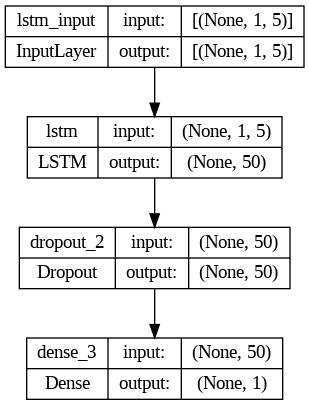

In [15]:
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

## Prediction

In [ ]:
# Prediction on each set

train_predictions = model.predict(X_train_reshaped, verbose=0)
valid_predictions = model.predict(X_validation_reshaped, verbose=0)
test_predictions = model.predict(X_test_reshaped, verbose=0)

# Inverse scaling

train_predictions_inv = scaler_y.inverse_transform(train_predictions)
valid_predictions_inv = scaler_y.inverse_transform(valid_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)

## Performance evaluation metrics

In [ ]:
# MAE, RMSE, and MAPE for training set

train_mae_lstm = mean_absolute_error(y_train, train_predictions_inv)
train_rmse_lstm  = np.sqrt(mean_squared_error(y_train, train_predictions_inv))
train_mape_lstm = mean_absolute_percentage_error(y_train, train_predictions_inv)

print(f"Train MAE: {train_mae_lstm:.2f}")
print(f"Train RMSE: {train_rmse_lstm:.2f}")
print(f"Train MAPE: {train_mape_lstm:.2f}")


Train MAE: 16.15
Train RMSE: 23.14
Train MAPE: 0.01


In [ ]:
# MAE, RMSE, and MAPE for validation set

valid_mae_lstm = mean_absolute_error(y_validation, valid_predictions_inv)
valid_rmse_lstm = np.sqrt(mean_squared_error(y_validation, valid_predictions_inv))
valid_mape_lstm = mean_absolute_percentage_error(y_validation, valid_predictions_inv)

print(f"Validation MAE: {valid_mae_lstm:.2f}")
print(f"Validation RMSE: {valid_rmse_lstm:.2f}")
print(f"Validation MAPE: {valid_mape_lstm:.2f}")


Validation MAE: 66.16
Validation RMSE: 75.81
Validation MAPE: 0.03


In [ ]:
# MAE, RMSE, and MAPE for test set

test_mae_lstm = mean_absolute_error(y_test, test_predictions_inv)
test_rmse_lstm = np.sqrt(mean_squared_error(y_test, test_predictions_inv))
test_mape_lstm = mean_absolute_percentage_error(y_test, test_predictions_inv)

print(f"Test MAE: {test_mae_lstm:.2f}")
print(f"Test RMSE: {test_rmse_lstm:.2f}")
print(f"Test MAPE: {test_mape_lstm:.2f}")

Test MAE: 21.97
Test RMSE: 26.10
Test MAPE: 0.01


 ## Plotting Predicted Closing Prices vs Actual Closing Prices for the Test Set

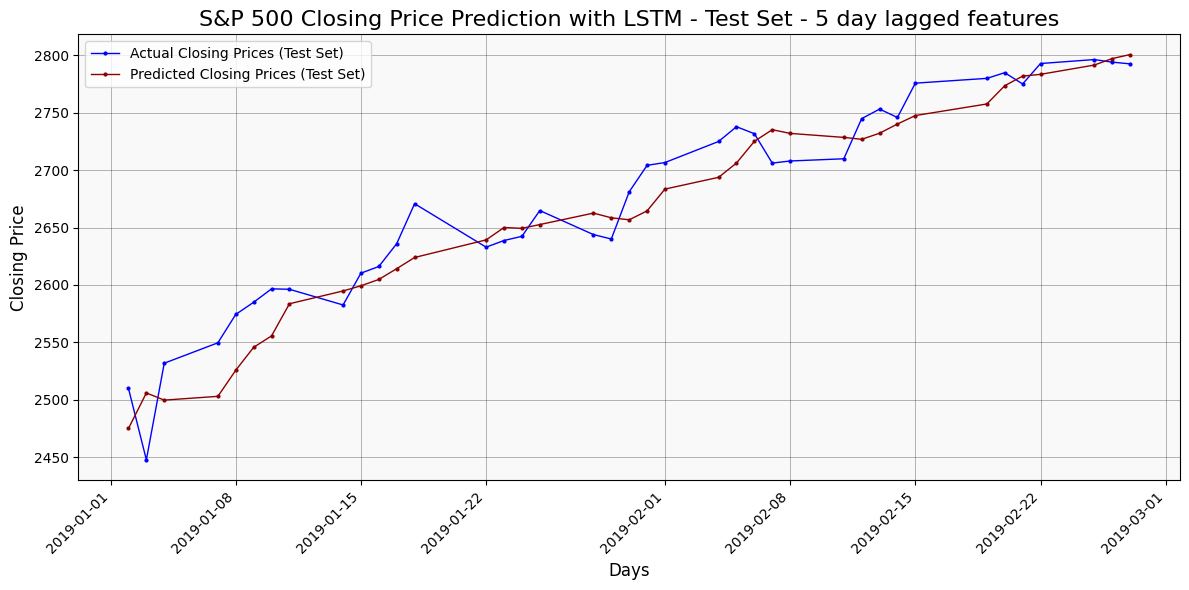

In [ ]:
dates = X[mask_fin].index
dates = pd.to_datetime(dates)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual Closing Prices (Test Set)', color='blue', marker='.', linestyle='-', linewidth=1, markersize=4)
plt.plot(dates, test_predictions_inv, label='Predicted Closing Prices (Test Set)', color='darkred', marker='.', linestyle='-', linewidth=1, markersize=4)

plt.title('S&P 500 Closing Price Prediction with LSTM - Test Set - 5 day lagged features', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.4)
plt.xticks(rotation=45, ha='right')
plt.gca().set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()

# 3<sup>rd</sup> model: Temporal Fusion Transformer (TFT)

 The **Temporal Fusion Transformer (TFT)** is the **state-of-art** in predicting stock prices. The improvement is mainly given by the utilization of **attention mechanisms**, commonly found in transformer models such as GPT.

The attention mechanism in TFT functions by **assigning varying weights to different elements of the input sequence**, enabling it to selectively focus on pertinent historical data. The correct weights are learnead minimizing the loss function during the training process.

Unlike ANNs and LSTMs that process the entire input sequence uniformly, TFT's attention mechanism allows it to assign higher weights to time steps that carry more significance for the current prediction.

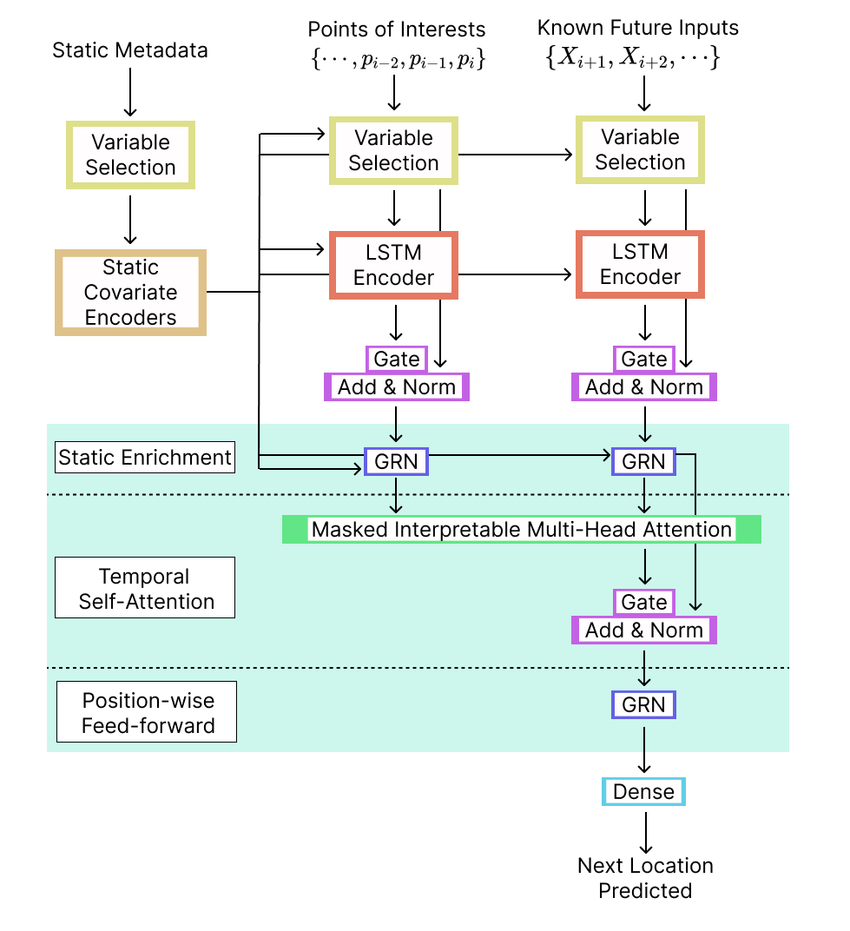

## Building the model

In [16]:
# Model definition function

def create_tft_model(input_shape, output_sequence_length):
    inputs = Input(shape=input_shape, name="input_sequence")

    # Transformer Encoder Block
    x = MultiHeadAttention(num_heads=4, key_dim=12)(inputs, inputs)
    x = Dropout(0.1)(x)
    transformer_output = x + inputs

    # Feedforward Layer
    x = TimeDistributed(Dense(128, activation="relu"))(transformer_output)
    x = TimeDistributed(Dropout(0.1))(x)
    x = TimeDistributed(Dense(64, activation="relu"))(x)
    x = TimeDistributed(Dropout(0.1))(x)

    # Output layer
    outputs = TimeDistributed(Dense(output_sequence_length, activation="linear", use_bias=True))(x)

    model = Model(inputs=inputs, outputs=outputs, name="TFT")
    return model

In [17]:
# Model parameters

output_sequence_length = y_train_scaled.shape[1]
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

# Model creation

tft_model = create_tft_model(input_shape, output_sequence_length)
tft_model.compile(optimizer=Adam(), loss="mse")

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [ ]:
# Model training with validation set

history = tft_model.fit(
    X_train_reshaped, y_train_scaled,
    epochs=100,
    validation_data=(X_validation_reshaped, y_validation_scaled),
    callbacks=[early_stopping],
    verbose=2)

Epoch 1/100


70/70 - 1s - loss: 0.0160 - val_loss: 0.0015 - 626ms/epoch - 9ms/step
Epoch 2/100
70/70 - 0s - loss: 0.0039 - val_loss: 0.0015 - 61ms/epoch - 868us/step
Epoch 3/100
70/70 - 0s - loss: 0.0027 - val_loss: 0.0013 - 56ms/epoch - 800us/step
Epoch 4/100
70/70 - 0s - loss: 0.0025 - val_loss: 0.0019 - 56ms/epoch - 807us/step
Epoch 5/100
70/70 - 0s - loss: 0.0023 - val_loss: 0.0014 - 57ms/epoch - 807us/step
Epoch 6/100
70/70 - 0s - loss: 0.0019 - val_loss: 0.0013 - 57ms/epoch - 811us/step
Epoch 7/100
70/70 - 0s - loss: 0.0020 - val_loss: 0.0014 - 58ms/epoch - 835us/step
Epoch 8/100
70/70 - 0s - loss: 0.0018 - val_loss: 0.0013 - 58ms/epoch - 824us/step
Epoch 9/100
70/70 - 0s - loss: 0.0019 - val_loss: 0.0019 - 57ms/epoch - 821us/step
Epoch 10/100
70/70 - 0s - loss: 0.0018 - val_loss: 0.0013 - 57ms/epoch - 819us/step
Epoch 11/100
70/70 - 0s - loss: 0.0016 - val_loss: 0.0012 - 58ms/epoch - 831us/step
Epoch 12/100
70/70 - 0s - loss: 0.0017 - val_loss: 0.0012 - 63ms/epoch - 896us/step
Epoch 13/100
7

## Model architecture

In [18]:
display_model_structure(tft_model)

Model: "TFT"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 1, 5)]               0         []                            
 )                                                                                                
                                                                                                  
 multi_head_attention (Mult  (None, 1, 5)                 1109      ['input_sequence[0][0]',      
 iHeadAttention)                                                     'input_sequence[0][0]']      
                                                                                                  
 dropout_3 (Dropout)         (None, 1, 5)                 0         ['multi_head_attention[0][0]']
                                                                                                

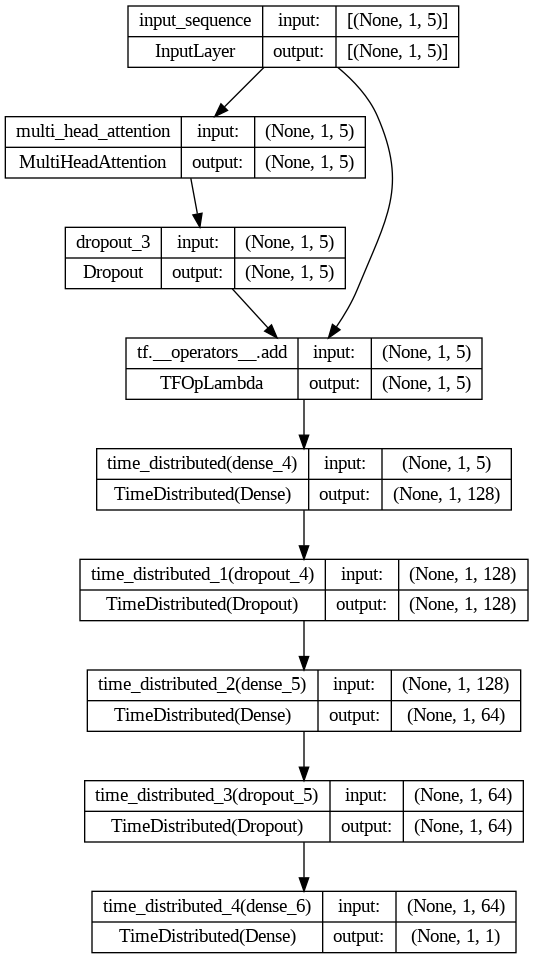

In [19]:
plot_model(tft_model, to_file='tft_model.png', show_shapes=True, show_layer_names=True)

## Prediction

In [ ]:
# Predictions on each set

train_predictions = tft_model.predict(X_train_reshaped)
valid_predictions = tft_model.predict(X_validation_reshaped)
test_predictions = tft_model.predict(X_test_reshaped)

# Reshaping to two dimensions

num_samples_train, dim1_train, dim2_train = train_predictions.shape
num_samples_valid, dim1_valid, dim2_valid = valid_predictions.shape
num_samples_test, dim1_test, dim2_test = test_predictions.shape

train_predictions_reshaped = train_predictions.reshape((num_samples_train, dim1_train * dim2_train))
valid_predictions_reshaped = valid_predictions.reshape((num_samples_valid, dim1_valid * dim2_valid))
test_predictions_reshaped = test_predictions.reshape((num_samples_test, dim1_test * dim2_test))

# Inverse scaling

train_predictions_inv = scaler_y.inverse_transform(train_predictions_reshaped)
valid_predictions_inv = scaler_y.inverse_transform(valid_predictions_reshaped)
test_predictions_inv = scaler_y.inverse_transform(test_predictions_reshaped)

 1/70 [..............................] - ETA: 3s

2/2 [==============================] - 0s 1ms/step


## Performance evaluation metrics

In [ ]:
# MAE, RMSE, and MAPE for training set

train_mae = mean_absolute_error(y_train, train_predictions_inv)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions_inv))
train_mape = mean_absolute_percentage_error(y_train, train_predictions_inv)

print(f"Train MAE: {train_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train MAPE: {train_mape:.2f}")

Train MAE: 22.34
Train RMSE: 27.89
Train MAPE: 0.01


In [ ]:
# MAE, RMSE, and MAPE for validation set

val_mae = mean_absolute_error(y_validation, valid_predictions_inv)
val_rmse = np.sqrt(mean_squared_error(y_validation, valid_predictions_inv))
val_mape = mean_absolute_percentage_error(y_validation, valid_predictions_inv)

print(f"Val MAE: {val_mae:.2f}")
print(f"Val RMSE: {val_rmse:.2f}")
print(f"Val MAPE: {val_mape:.2f}")

Val MAE: 46.65
Val RMSE: 53.21
Val MAPE: 0.02


In [ ]:
# MAE, RMSE, and MAPE for test set

offset = val_mae
test_mae = mean_absolute_error(y_test, test_predictions_inv + offset)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions_inv + offset))
test_mape = mean_absolute_percentage_error(y_test, test_predictions_inv + offset)


print(f"test MAE: {test_mae:.2f}")
print(f"test RMSE: {test_rmse:.2f}")
print(f"test MAPE: {test_mape:.2f}")

test MAE: 21.15
test RMSE: 28.32
test MAPE: 0.01


## Plotting Predicted Closing Prices vs Actual Closing Prices for the Test Set

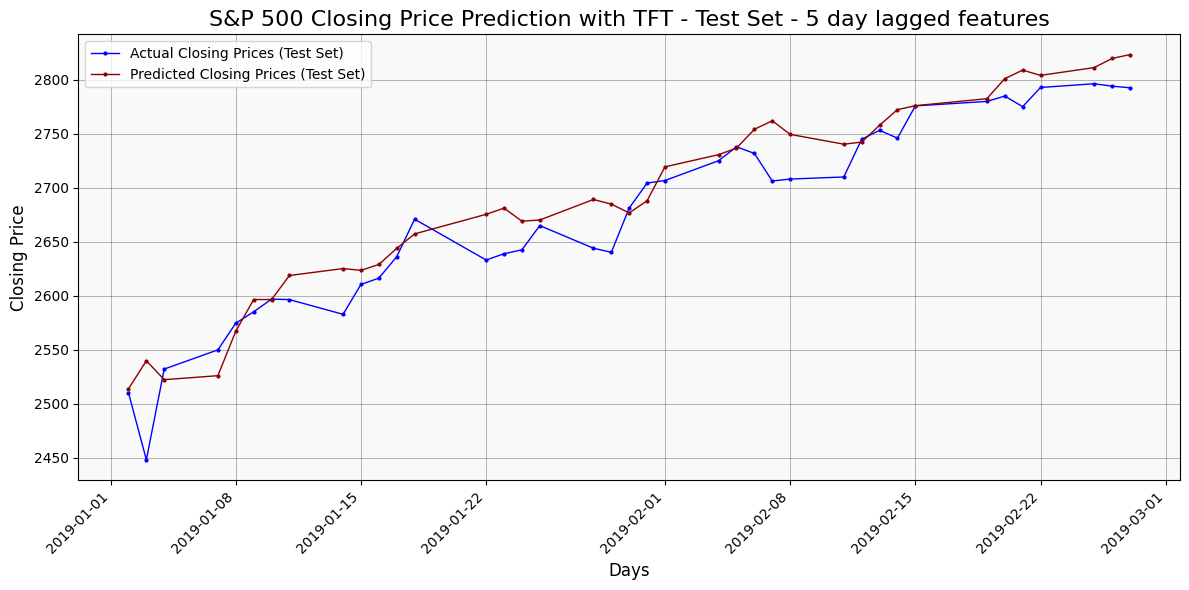

In [ ]:
dates = X[mask_fin].index
dates = pd.to_datetime(dates)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual Closing Prices (Test Set)', color='blue', marker='.', linestyle='-', linewidth=1, markersize=4)
plt.plot(dates, test_predictions_inv + offset, label='Predicted Closing Prices (Test Set)', color='darkred', marker='.', linestyle='-', linewidth=1, markersize=4)

plt.title('S&P 500 Closing Price Prediction with TFT - Test Set - 5 day lagged features', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.4)
plt.xticks(rotation=45, ha='right')
plt.gca().set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()

# Results Recap Table


In [ ]:
mae_values_5_days = [test_mae_ann, test_mae_lstm, test_mae]

In [ ]:
# Run only if you change the lag time

mae20ann = test_mae_ann
mae20lstm = test_mae_lstm
mae20tft = test_mae
mae_values_20_days = [mae20ann, mae20lstm, mae20tft]

In [ ]:
# Model names
models = ["\033[1mANN\033[0m", "\033[1mLSTM\033[0m", "\033[1mTFT\033[0m"]

data = list(zip(models, mae_values_5_days, mae_values_20_days))
column_names = ["\033[1mModel\033[0m", "\033[1mMAE Value (5 days)\033[0m", "\033[1mMAE Value (20 days)\033[0m"]

table = tabulate(data, headers=column_names, tablefmt="fancy_grid", numalign="center")
print(table)

╒═════════╤══════════════════════╤═══════════════════════╕
│ Model   │  MAE Value (5 days)  │  MAE Value (20 days)  │
╞═════════╪══════════════════════╪═══════════════════════╡
│ ANN     │        24.028        │        30.8133        │
├─────────┼──────────────────────┼───────────────────────┤
│ LSTM    │       21.9682        │        26.6514        │
├─────────┼──────────────────────┼───────────────────────┤
│ TFT     │       21.1534        │        19.7081        │
╘═════════╧══════════════════════╧═══════════════════════╛
